In [1]:
import numpy as np
import pandas as pd

In [2]:
# File path
file_path = 'Tracks\T53434.si'

# Load the .si file into a DataFrame
df = pd.read_csv(file_path, delim_whitespace=True,  # You can change 'delim_whitespace' to another delimiter if needed
                 names=["TrackID", "year", "month", "day", "hour", "minute", "second", "latitude", "longitude"])

# Display the first few rows
print(df.head())


  TrackID  year  month  day  hour  minute  second  latitude  longitude
0  T53434  2011      9   15     8      55      50 -21.17789   55.26960
1  T53434  2011      9   15     9       2       6 -21.17185   55.24230
2  T53434  2011      9   15     9      43      17 -21.17607   55.25989
3  T53434  2011      9   15    13      40      38 -21.20071   55.27747
4  T53434  2011      9   15    15      25      58 -21.18690   55.25729


In [3]:
import pandas as pd
import numpy as np


def calculate_initial_compass_bearing(lat1, lon1, lat2, lon2):
    """
    Calculates the bearing between two points.
    The formula used to calculate the bearing is the following:
        θ = atan2(sin(Δlong).cos(lat2), cos(lat1).sin(lat2) - sin(lat1).cos(lat2).cos(Δlong))
    :Parameters:
      - `lat1, lon1`: The latitude and longitude of the first point in degrees.
      - `lat2, lon2`: The latitude and longitude of the second point in degrees.
    :Returns:
      The bearing in degrees.
    """
    # Convert from degrees to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    dlon = lon2 - lon1

    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(dlon))

    initial_bearing = np.arctan2(x, y)

    # Convert bearing from radians to degrees
    initial_bearing = np.degrees(initial_bearing)

    # Normalize the bearing to be between 0° and 360°
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

# Calculate bearing for each step
df['bearing'] = np.nan
for i in range(1, len(df)):
    lat1, lon1 = df.loc[i-1, 'latitude'], df.loc[i-1, 'longitude']
    lat2, lon2 = df.loc[i, 'latitude'], df.loc[i, 'longitude']
    df.loc[i, 'bearing'] = calculate_initial_compass_bearing(lat1, lon1, lat2, lon2)

# Display the updated DataFrame with bearings
print(df.head())


  TrackID  year  month  day  hour  minute  second  latitude  longitude  \
0  T53434  2011      9   15     8      55      50 -21.17789   55.26960   
1  T53434  2011      9   15     9       2       6 -21.17185   55.24230   
2  T53434  2011      9   15     9      43      17 -21.17607   55.25989   
3  T53434  2011      9   15    13      40      38 -21.20071   55.27747   
4  T53434  2011      9   15    15      25      58 -21.18690   55.25729   

      bearing  
0         NaN  
1  283.342542  
2  104.431234  
3  146.369694  
4  306.274484  


In [ ]:
import MagneticModel as magmod
magmodel=magmod.MagneticModel(sample_resolution=None) #should change to get magnetic fields from the right time
df['Intensity'] = np.nan
df['Inclination']=np.nan
for i in range(1, len(df)):
    _, _, _, _, _, df.loc[i, 'Intensity'],df.loc[i, 'Inclination']=magmodel.evaluate_model(df.loc[i, 'latitude'], df.loc[i, 'longitude'])
print(df.head())

In [5]:
import os
print(os.getcwd())
os.chdir('C:/Users/18479/OneDrive/Desktop/Code Turtle Project/PythonPortMagModel/')

c:\Users\18479\OneDrive\Desktop\Code Turtle Project


In [10]:
import numpy as np
import random
import pickle
import numpy as np
goal_lat,goal_lon=17.7,56.3
#with open('magmodel.pkl', 'rb') as file:
#    magmodel = pickle.load(file)
_,_,_,_,_,goal_I_INCL,goal_F_TOTAL=magmodel.evaluate_model(goal_lat,goal_lon)

# Simulated annealing parameters
initial_temperature = 1000
cooling_rate = 0.95
max_iterations = 500

# Your error function from the provided code
def error_function(A, df, goal_F_TOTAL, goal_I_INCL,  goal_lat, goal_lon):
    df['simulbearing'] = np.nan
    df['bearingerr'] = np.nan
    
    for i in range(1, len(df)):
        velocity = A @ np.array([goal_F_TOTAL - df.loc[i-1, 'Intensity'], goal_I_INCL - df.loc[i-1, 'Inclination']])
        new_lon = df.loc[i-1, 'longitude'] + velocity[0] * 1
        new_lat = df.loc[i-1, 'latitude'] + velocity[1] * 1
        
        df.loc[i, 'simulbearing'] = calculate_initial_compass_bearing(df.loc[i-1, 'latitude'], df.loc[i-1, 'longitude'], new_lat, new_lon)
        df.loc[i, 'bearingerr'] = min(abs(df.loc[i, 'simulbearing'] - df.loc[i, 'bearing']),
                                      (360 - abs(df.loc[i, 'simulbearing'] - df.loc[i, 'bearing'])))
    
    total_error = np.linalg.norm(df['bearingerr'].dropna())  # Use the norm to calculate the total error
    return total_error

# Function to perturb the matrix A (randomly change a small value in the matrix)
def perturb_matrix(A, perturbation_scale=0.1):
    perturbation = np.random.uniform(-perturbation_scale, perturbation_scale, A.shape)
    return A + perturbation

# Simulated annealing function
def simulated_annealing(df, goal_F_TOTAL, goal_I_INCL, goal_lat, goal_lon):
    # Initialize A (2x2 matrix) randomly
    A = np.random.rand(2, 2)
    current_error = error_function(A, df, goal_F_TOTAL, goal_I_INCL, goal_lat, goal_lon)
    
    temperature = initial_temperature

    for iteration in range(max_iterations):
        # Perturb the matrix A
        new_A = perturb_matrix(A)
        
        # Calculate the new error
        new_error = error_function(new_A, df, goal_F_TOTAL, goal_I_INCL, goal_lat, goal_lon)
        
        # If the new error is smaller, or if we randomly accept a worse solution (based on temperature)
        if new_error < current_error or random.uniform(0, 1) < np.exp((current_error - new_error) / temperature):
            A = new_A
            current_error = new_error
        
        # Cool down the temperature
        temperature *= cooling_rate

        # Optionally print the progress
        if iteration % 50 == 0:
            print(f"Iteration {iteration}, Error: {current_error}, A: \n{A}")
    
    return A, current_error

# Call simulated annealing with the required parameters
best_A, best_error = simulated_annealing(df, goal_F_TOTAL, goal_I_INCL, goal_lat, goal_lon)
print("Best matrix A found:\n", best_A)
print("Best error:", best_error)

Iteration 0, Error: 4727.210498007591, A: 
[[0.88872055 0.78057279]
 [0.49609636 0.10239617]]
Iteration 50, Error: 4757.654321199499, A: 
[[1.42255743 0.96131158]
 [0.51342167 0.15356816]]
Iteration 100, Error: 4264.817104017383, A: 
[[0.98383837 0.18814632]
 [1.27389433 0.24680994]]
Iteration 150, Error: 4251.825278507284, A: 
[[0.8227777  0.11943863]
 [1.43472341 0.63364678]]
Iteration 200, Error: 4251.619249271032, A: 
[[ 0.76046377 -0.08151844]
 [ 1.44362996  0.63289925]]
Iteration 250, Error: 4251.4145679153635, A: 
[[ 0.78987883 -0.14583949]
 [ 1.43874477  0.53128188]]
Iteration 300, Error: 4251.386908136009, A: 
[[ 0.82387533 -0.15993441]
 [ 1.43136572  0.48945979]]
Iteration 350, Error: 4251.386908136009, A: 
[[ 0.82387533 -0.15993441]
 [ 1.43136572  0.48945979]]
Iteration 400, Error: 4251.386908136009, A: 
[[ 0.82387533 -0.15993441]
 [ 1.43136572  0.48945979]]
Iteration 450, Error: 4251.386908136009, A: 
[[ 0.82387533 -0.15993441]
 [ 1.43136572  0.48945979]]
Best matrix A foun

[[1.  1.  1.  ... 1.  1.  1. ]
 [1.  1.  1.  ... 1.  1.  1. ]
 [1.  1.  1.  ... 1.  1.  1. ]
 ...
 [1.  1.  1.  ... 1.  1.  1. ]
 [1.  1.  1.  ... 1.  1.  1. ]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]]


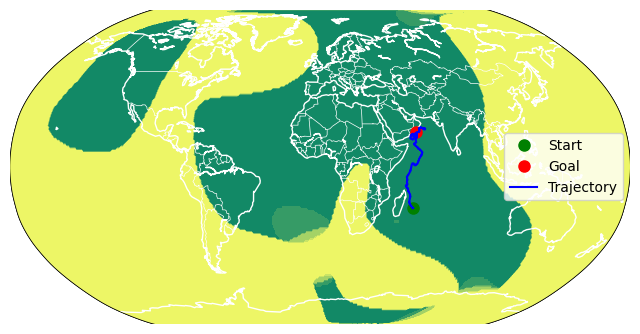

[[1.  1.  1.  ... 1.  1.  1. ]
 [1.  1.  1.  ... 1.  1.  1. ]
 [1.  1.  1.  ... 1.  1.  1. ]
 ...
 [1.  1.  1.  ... 1.  1.  1. ]
 [1.  1.  1.  ... 1.  1.  1. ]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]]
[[0.  0.5 0.5 ... 0.5 0.5 0. ]
 [1.  1.  1.  ... 1.  1.  1. ]
 [1.  1.  1.  ... 1.  1.  1. ]
 ...
 [1.  1.  1.  ... 1.  1.  1. ]
 [1.  1.  1.  ... 1.  1.  1. ]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]]


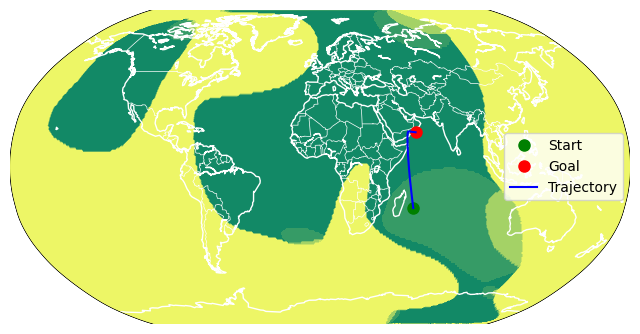

In [16]:
import AxesmMagneticMap as axesmap
import Agent as agent
map = axesmap.AxesmMagneticMap(magmodel)
map.initialize_axes()
map.update_agent_start(df.loc[1,"latitude"],df.loc[1,"longitude"])  
map.update_agent_goal(goal_lat,goal_lon)  
map.update_agent_trajectory(df["latitude"],df["longitude"])
map.show()
map2 = axesmap.AxesmMagneticMap(magmodel)
map2.initialize_axes()
Turtle=agent.Agent(magmodel,verbose=False)
Turtle.SetAMatrix(best_A)
Turtle.SetStart(df.loc[1,"latitude"],df.loc[1,"longitude"])
Turtle.SetGoal(goal_lat,goal_lon)
Turtle.Reset()
Turtle.Run()
Lats,Longs=Turtle.GetTraj()
map2.update_agent_start(df.loc[1,"latitude"],df.loc[1,"longitude"])  
map2.update_agent_goal(goal_lat,goal_lon)  
map2.update_agent_trajectory(Lats,Longs)
map2.draw_stability_mesh(Turtle.A)
map2.show()